Lab
==========================================
Text Feature Extraction for Classification
------------------------------------------
Alessandro D. Gagliardi  
*(adapted from Olivier Grisel's tutorial)*

<style>
div.input {
    width: 105ex; /* about 80 chars + buffer */
}
div.text_cell {
    width: 105ex; /* instead of 100%, */
}
div.text_cell_render {
    /*font-family: "Helvetica Neue", Arial, Helvetica, Geneva, sans-serif;*/
    font-family: "Charis SIL", serif !important; /* Make non-code text serif. */
    line-height: 145% !important; /* added for some line spacing of text. */
    width: 105ex !important; /* instead of 'inherit' for shorter lines */
}
/* Set the size of the headers */
div.text_cell_render h1 {
    font-size: 18pt;
}
div.text_cell_render h2 {
    font-size: 14pt;
}
.CodeMirror {
     font-family: Consolas, monospace;
}
</style>

Outline of this section:

- Turn a corpus of text documents into **feature vectors** using a **Bag of Words** representation,
- Train a simple text classifier on the feature vectors,
- Wrap the vectorizer and the classifier with a **pipeline**,
- Cross-validation and **model selection** on the pipeline.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from seaborn import plt

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

### Check that you have the datasets

In [2]:
%run fetch_data.py

Using existing dataset folder:X:\Python Scripts\ds_class\datasets
Checking availability of the 20 newsgroups dataset
Found archive: X:\Python Scripts\ds_class\datasets\20news-bydate.tar.gz
Decompressing X:\Python Scripts\ds_class\datasets\20news-bydate.tar.gz
Checking that the 20 newsgroups files exist...
=> Success!
Checking availability of the titanic dataset
=> Success!


In [3]:
!ls -lh datasets/

'ls' is not recognized as an internal or external command,
operable program or batch file.


## Text Classification in 20 lines of Python

Let's start by implementing a canonical text classification example:

- The 20 newsgroups dataset: around 18000 text posts from 20 newsgroups forums
- Bag of Words features extraction with TF-IDF weighting
- Naive Bayes classifier or Linear Support Vector Machine for the classifier itself

In [10]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Load the text data
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
twenty_train_small = load_files('datasets/20news-bydate-train/',
    categories=categories, encoding='latin-1')
twenty_test_small = load_files('datasets/20news-bydate-test/',
    categories=categories, encoding='latin-1')

# Turn the text documents into vectors of word frequencies
vectorizer = TfidfVectorizer(min_df=2)
X_train = vectorizer.fit_transform(twenty_train_small.data)
y_train = twenty_train_small.target

# Fit a classifier on the training set
classifier = MultinomialNB().fit(X_train, y_train)
print("Training score: {0:.1f}%".format(
    classifier.score(X_train, y_train) * 100))

# Evaluate the classifier on the testing set
X_test = vectorizer.transform(twenty_test_small.data)
y_test = twenty_test_small.target
print("Testing score: {0:.1f}%".format(
    classifier.score(X_test, y_test) * 100))

Training score: 95.1%
Testing score: 85.1%


[Multinomial Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)
--------------------------------------------------------
`MultinomialNB` implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). The distribution is parametrized by vectors $\theta_y = (\theta_{y1},\ldots,\theta_{yn})$ for each class $y$, where $n$ is the number of features (in text classification, the size of the vocabulary) and $\theta_{yi}$ is the probability $P(x_i \mid y)$ of feature $i$ appearing in a sample belonging to class $y$.

The parameters $\theta_y$ is estimated by a smoothed version of maximum likelihood, i.e. relative frequency counting:

$$ \hat{\theta}_{yi} = \frac{ N_{yi} + \alpha}{N_y + \alpha n} $$

where $N_{yi} = \sum_{x \in T} x_i$ is the number of times feature $i$ appears in a sample of class $y$ in the training set $T$, and $N_{y} = \sum_{i=1}^{|T|} N_{yi}$ is the total count of all features for class $y$.

The smoothing priors $\alpha \ge 0$ accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting $\alpha = 1$ is called Laplace smoothing, while $\alpha < 1$ is called Lidstone smoothing.

Let's now decompose what we just did to understand and customize each step.

### Loading the Dataset

Let's explore the dataset loading utility without passing a list of categories: in this case we load the full 20 newsgroups dataset in memory. The source website for the 20 newsgroups already provides a date-based train / test split that is made available using the `subset` keyword argument: 

In [5]:
!ls datasets/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
ls -lh datasets/20news-bydate-train

Invalid switch - "20news-bydate-train".


In [7]:
ls -lh datasets/20news-bydate-train/alt.atheism/ | head -n27

'head' is not recognized as an internal or external command,
operable program or batch file.


The `load_files` function can load text files from a 2 levels folder structure assuming folder names represent categories:

In [8]:
print(load_files.__doc__)

Load text files with categories as subfolder names.

    Individual samples are assumed to be files stored a two levels folder
    structure such as the following:

        container_folder/
            category_1_folder/
                file_1.txt
                file_2.txt
                ...
                file_42.txt
            category_2_folder/
                file_43.txt
                file_44.txt
                ...

    The folder names are used has supervised signal label names. The
    individual file names are not important.

    This function does not try to extract features into a numpy array or
    scipy sparse matrix. In addition, if load_content is false it
    does not try to load the files in memory.

    To use text files in a scikit-learn classification or clustering
    algorithm, you will need to use the `sklearn.feature_extraction.text`
    module to build a feature extraction transformer that suits your
    problem.

    If you set load_content=True, you sho

In [9]:
all_twenty_train = load_files('datasets/20news-bydate-train/',
  encoding='latin-1', random_state=42)
all_twenty_test = load_files('datasets/20news-bydate-test/',
    encoding='latin-1', random_state=42)

KeyboardInterrupt: 

In [ ]:
all_twenty_train.keys()
all_twenty_train.filenames

In [ ]:
all_target_names = all_twenty_train.target_names
all_target_names

In [ ]:
all_twenty_train.target

In [ ]:
all_twenty_train.target.shape

In [ ]:
all_twenty_test.target.shape

In [ ]:
len(all_twenty_train.data)

In [ ]:
type(all_twenty_train.data[0])

In [ ]:
def display_sample(i, dataset):
    print("Class name: " + dataset.target_names[dataset.target[i]])
    print("Text content:\n")
    print(dataset.data[i])

In [ ]:
display_sample(0, all_twenty_train)

In [ ]:
display_sample(1, all_twenty_train)

Let's compute the (uncompressed, in-memory) size of the training and test sets in MB assuming an 8-bit encoding (in this case, all chars can be encoded using the latin-1 charset).

In [ ]:
def text_size(text, charset='iso-8859-1'):
    return len(text.encode(charset)) * 8 * 1e-6

train_size_mb = sum(text_size(text) for text in all_twenty_train.data) 
test_size_mb = sum(text_size(text) for text in all_twenty_test.data)

print("Training set size: {0} MB".format(int(train_size_mb)))
print("Testing set size: {0} MB".format(int(test_size_mb)))

If we only consider a small subset of the 4 categories selected from the initial example:

In [ ]:
train_small_size_mb = sum(text_size(text) for text in twenty_train_small.data) 
test_small_size_mb = sum(text_size(text) for text in twenty_test_small.data)

print("Training set size: {0} MB".format(int(train_small_size_mb)))
print("Testing set size: {0} MB".format(int(test_small_size_mb)))

### Extracting Text Features

* Terms that occur in only a few documents are often more valuable than ones that occur in many – inverse document frequency (${IDF}_j$)
* The more often a term occurs in a document, the more likely it is to be important for that document – term frequency (${TF}_{ij}$)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

TfidfVectorizer()

In [ ]:
vectorizer = TfidfVectorizer(min_df=1)

%time X_train_small = vectorizer.fit_transform(twenty_train_small.data)

The results is not a `numpy.array` but instead a `scipy.sparse` matrix. _(Similar to the DocumentTermMatrix in R's `tm` library.)_ This datastructure is quite similar to a 2D numpy array but it does not store the zeros.

In [ ]:
X_train_small

scipy.sparse matrices also have a shape attribute to access the dimensions:

In [ ]:
n_samples, n_features = X_train_small.shape

This dataset has around 2000 samples (the rows of the data matrix):

In [ ]:
n_samples

This is the same value as the number of strings in the original list of text documents:

In [ ]:
len(twenty_train_small.data)

The columns represent the individual token occurrences:

In [ ]:
n_features

This number is the size of the vocabulary of the model extracted during fit in a Python dictionary:

In [ ]:
type(vectorizer.vocabulary_)

In [ ]:
len(vectorizer.vocabulary_)

The keys of the `vocabulary_` attribute are also called feature names and can be accessed as a list of strings.

In [ ]:
len(vectorizer.get_feature_names())

Here are the first 10 elements (sorted in lexicographical order):

In [ ]:
vectorizer.get_feature_names()[:10]

Let's have a look at the features from the middle:

In [ ]:
vectorizer.get_feature_names()[n_features / 2:n_features / 2 + 10]

### Training a Classifier on Text Features

We have previously extracted a vector representation of the training corpus and put it into a variable name `X_train_small`. To train a supervised model, in this case a classifier, we also need 

In [ ]:
y_train_small = twenty_train_small.target

In [ ]:
y_train_small.shape

We can shape that we have the same number of samples for the input data and the labels:

In [ ]:
X_train_small.shape[0] == y_train_small.shape[0]

We can now train a classifier, for instance a Multinomial Naive Bayesian classifier:

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=0.1)
clf

In [ ]:
clf.fit(X_train_small, y_train_small)

We can now evaluate the classifier on the testing set. Let's first use the builtin score function, which is the rate of correct classification in the test set:

In [ ]:
X_test_small = vectorizer.transform(twenty_test_small.data)
y_test_small = twenty_test_small.target

In [ ]:
X_test_small.shape

In [ ]:
y_test_small.shape

In [ ]:
clf.score(X_test_small, y_test_small)

We can also compute the score on the train set and observe that the model is both overfitting and underfitting a bit at the same time:

In [ ]:
clf.score(X_train_small, y_train_small)

### Alternative evaluation metrics

Naïve Bayes is a probabilistic models: instead of just predicting a binary outcome (alt.atheism or talk.religion) given the input features it can also estimates the posterior probability of the outcome given the input features using the `predict_proba` method:

In [ ]:
target_predicted_proba = clf.predict_proba(X_test_small)
target_predicted_proba[:5]
pd.DataFrame(target_predicted_proba[:5], columns = twenty_train_small.target_names)

By default the decision threshold is 0.5: if we vary the decision threshold from 0 to 1 we could generate a family of binary classifier models that address all the possible trade offs between false positive and false negative prediction errors.

We can summarize the performance of a binary classifier for all the possible thresholds by plotting the ROC curves and quantifying the area under the curve (AUC):

In [ ]:
def plot_roc_curve(target_test, target_predicted_proba, categories):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc
    
    for pos_label, category in enumerate(categories):
        fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, pos_label], pos_label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} ROC curve (area = {:.3f})'.format(category, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [ ]:
plot_roc_curve(y_test_small, target_predicted_proba, twenty_test_small.target_names)

Here the area under ROC curve ranges between .963 and .974. The ROC-AUC score of a random model is expected to 0.5 on average while the accuracy score of a random model depends on the class imbalance of the data. ROC-AUC can be seen as a way to callibrate the predictive accuracy of a model against class imbalance.

### Introspecting the Behavior of the Text Vectorizer

The text vectorizer has many parameters to customize it's behavior, in particular how it extracts tokens:

In [ ]:
TfidfVectorizer()

In [ ]:
print(TfidfVectorizer.__doc__)

The easiest way to introspect what the vectorizer is actually doing for a given test of parameters is call the `vectorizer.build_analyzer()` to get an instance of the text analyzer it uses to process the text:

In [ ]:
analyzer = TfidfVectorizer().build_analyzer()
analyzer("I love scikit-learn: this is a cool Python lib!")

You can notice that all the tokens are lowercase, that the single letter word "I" was dropped, and that hyphenation is used. Let's change some of that default behavior:

In [ ]:
analyzer = TfidfVectorizer(
    preprocessor=lambda text: text,  # disable lowercasing
    token_pattern=ur'(?u)\b[\w-]+\b', # treat hyphen as a letter
                                      # do not exclude single letter tokens
).build_analyzer()

analyzer("I love scikit-learn: this is a cool Python lib!")

The analyzer name comes from the Lucene parlance: it wraps the sequential application of:

- text preprocessing (processing the text documents as a whole, e.g. lowercasing)
- text tokenization (splitting the document into a sequence of tokens)
- token filtering and recombination (e.g. n-grams extraction, see later)

The analyzer system of scikit-learn is much more basic than lucene's though.

**Exercise**:

- Write a pre-processor callable (e.g. a python function) to remove the headers of the text a newsgroup post.
- Vectorize the data again and measure the impact on performance of removing the header info from the dataset.
- Do you expect the performance of the model to improve or decrease? What is the score of a uniform random classifier on the same dataset?

Hint: the `TfidfVectorizer` class can accept python functions to customize the `preprocessor`, `tokenizer` or `analyzer` stages of the vectorizer.
    
- type `TfidfVectorizer()` alone in a cell to see the default value of the parameters

- type `TfidfVectorizer.__doc__` to print the constructor parameters doc or `?` suffix operator on a any Python class or method to read the docstring or even the `jQuery203031440189930439577_1424627223304` operator to read the source code.

**Solution**:

Let's write a Python function to strip the post headers and only retain the body (text after the first blank line):

In [ ]:
def strip_headers(post):
    """Find the first blank line and drop the headers to keep the body"""
    if '\n\n' in post:
        headers, body = post.split('\n\n', 1)
        return body.lower()
    else:
        # Unexpected post inner-structure, be conservative
        # and keep everything
        return post.lower()

Let's try it on the first post. Here is the original post content, including the headers:

In [ ]:
original_text = all_twenty_train.data[0]
print(original_text)

Here is the result of applying our header stripping function:

In [ ]:
text_body = strip_headers(original_text)
print(text_body)

Let's plug our function in the vectorizer and retrain a naive Bayes classifier (as done initially):

In [ ]:
strip_vectorizer = TfidfVectorizer(preprocessor=strip_headers, min_df=2)
X_train_small_stripped = strip_vectorizer.fit_transform(
    twenty_train_small.data)

y_train_small_stripped = twenty_train_small.target

classifier = MultinomialNB().fit(
  X_train_small_stripped, y_train_small_stripped)

plt.hist()

print("Training score: {0:.1f}%".format(
    classifier.score(X_train_small_stripped, y_train_small_stripped) * 100))

X_test_small_stripped = strip_vectorizer.transform(twenty_test_small.data)
y_test_small_stripped = twenty_test_small.target
print("Testing score: {0:.1f}%".format(
    classifier.score(X_test_small_stripped, y_test_small_stripped) * 100))

So indeed the header data is making the problem easier (cheating one could say) but naive Bayes classifier can still guess 80% of the time against 1 / 4 == 25% mean score for a random guessing on the small subset with 4 target categories.

## Model Selection of the Naive Bayes Classifier Parameter Alone

The `MultinomialNB` class is a good baseline classifier for text as it's fast and has few parameters to tweak:

In [ ]:
MultinomialNB()

In [ ]:
print(MultinomialNB.__doc__)

By reading the doc we can see that the `alpha` parameter is a good candidate to adjust the model for the bias (underfitting) vs variance (overfitting) trade-off.

## Setting Up a Pipeline for Cross Validation and Model Selection of the Feature Extraction parameters

The feature extraction class has many options to customize its behavior:

In [ ]:
print(TfidfVectorizer.__doc__)

In order to evaluate the impact of the parameters of the feature extraction one can chain a configured feature extraction and classifier:

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline((
    ('vec', TfidfVectorizer()),
    ('clf', MultinomialNB()),
))

Such a pipeline can then be cross validated or even grid searched:

In [58]:
from sklearn.cross_validation import cross_val_score
from scipy.stats import sem

scores = cross_val_score(pipeline, twenty_train_small.data,
                         twenty_train_small.target, cv=3, n_jobs=3)
scores.mean(), sem(scores)

(0.87461982902109792, 0.0040823205976758233)

For the grid search, the parameters names are prefixed with the name of the pipeline step using "__" as a separator:

In [69]:
from sklearn.grid_search import GridSearchCV

parameters = {
    'vec__max_df': [0.8, 1.0],
    'vec__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': np.logspace(-5, 0, 6)
}

gs = GridSearchCV(pipeline, parameters, verbose=2, refit=False, n_jobs=3)
_ = gs.fit(twenty_train_small.data, twenty_train_small.target)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=3)]: Done   1 jobs       | elapsed:    4.7s
[Parallel(n_jobs=3)]: Done  41 jobs       | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done  68 out of  72 | elapsed:  3.4min remaining:   11.8s
[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:  3.6min finished


[CV] vec__max_df=0.8, vec__ngram_range=(1, 1), clf__alpha=1e-05 ......
[CV] vec__max_df=0.8, vec__ngram_range=(1, 1), clf__alpha=1e-05 ......
[CV] vec__max_df=0.8, vec__ngram_range=(1, 1), clf__alpha=1e-05 ......
[CV]  vec__max_df=0.8, vec__ngram_range=(1, 1), clf__alpha=1e-05 -   4.6s[CV]  vec__max_df=0.8, vec__ngram_range=(1, 1), clf__alpha=1e-05 -   4.5s[CV]  vec__max_df=0.8, vec__ngram_range=(1, 1), clf__alpha=1e-05 -   4.5s


[CV] vec__max_df=0.8, vec__ngram_range=(1, 2), clf__alpha=1e-05 ......[CV] vec__max_df=0.8, vec__ngram_range=(1, 2), clf__alpha=1e-05 ......[CV] vec__max_df=0.8, vec__ngram_range=(1, 2), clf__alpha=1e-05 ......


[CV]  vec__max_df=0.8, vec__ngram_range=(1, 2), clf__alpha=1e-05 -  11.3s[CV]  vec__max_df=0.8, vec__ngram_range=(1, 2), clf__alpha=1e-05 -  11.5s[CV]  vec__max_df=0.8, vec__ngram_range=(1, 2), clf__alpha=1e-05 -  11.6s


[CV] vec__max_df=1.0, vec__ngram_range=(1, 1), clf__alpha=1e-05 ......[CV] vec__max_df=1.0, vec__ngram_range=(1, 1), clf__alpha=1e

In [68]:
gs.best_score_

0.96361848574237952

In [61]:
gs.best_params_

{'clf__alpha': 0.01, 'vec__max_df': 0.8, 'vec__ngram_range': (1, 2)}

## Introspecting Model Performance

### Displaying the Most Discriminative Features

Let's fit a model on the small dataset and collect info on the fitted components:

In [62]:
pipeline = Pipeline((
    ('vec', TfidfVectorizer(max_df = 0.8, ngram_range = (1, 2), use_idf=True)),
    ('clf', MultinomialNB(alpha = 0.001)),
))
_ = pipeline.fit(twenty_train_small.data, twenty_train_small.target)

In [63]:
vec_name, vec = pipeline.steps[0]
clf_name, clf = pipeline.steps[1]

feature_names = vec.get_feature_names()
target_names = twenty_train_small.target_names

feature_weights = clf.coef_

feature_weights.shape

(4, 279569)

By sorting the feature weights on the linear model and asking the vectorizer what their names is, one can get a clue on what the model did actually learn on the data:

In [64]:
def display_important_features(feature_names, target_names, weights, n_top=30):
    for i, target_name in enumerate(target_names):
        print(u"Class: " + target_name)
        print(u"")
        
        sorted_features_indices = weights[i].argsort()[::-1]
        
        most_important = sorted_features_indices[:n_top]
        print(u", ".join(u"{0}: {1:.4f}".format(feature_names[j], weights[i, j])
                        for j in most_important))
        print(u"...")
        
        least_important = sorted_features_indices[-n_top:]
        print(u", ".join(u"{0}: {1:.4f}".format(feature_names[j], weights[i, j])
                        for j in least_important))
        print(u"")
        
display_important_features(feature_names, target_names, feature_weights)

Class: alt.atheism

is: -6.0027, that: -6.0312, you: -6.2511, it: -6.3314, edu: -6.4635, not: -6.5979, keith: -6.6737, are: -6.7286, god: -6.7621, be: -6.7679, this: -6.8508, have: -6.8571, as: -6.9286, for: -6.9742, com: -6.9941, was: -7.0117, if: -7.0161, what: -7.0188, caltech edu: -7.0239, caltech: -7.0395, but: -7.0456, we: -7.0484, they: -7.0532, or: -7.0633, your: -7.0776, an: -7.0856, he: -7.0863, people: -7.1103, one: -7.1105, do: -7.1638
...
occultic writings: -15.9805, occurred close: -15.9805, occurred long: -15.9805, ocean of: -15.9805, occurs program: -15.9805, ocean marvin: -15.9805, ocean mariner: -15.9805, ocean in: -15.9805, ocean dynamics: -15.9805, ocean dt: -15.9805, ocean and: -15.9805, ocean aleph: -15.9805, ocean after: -15.9805, ocean: -15.9805, occurs under: -15.9805, occurs this: -15.9805, occurs now: -15.9805, occurred think: -15.9805, occurs may: -15.9805, occurs in: -15.9805, occurs even: -15.9805, occurs during: -15.9805, occurs at: -15.9805, occurs as: -

### Displaying the per-class Classification Reports

In [65]:
from sklearn.metrics import classification_report

predicted = pipeline.predict(twenty_test_small.data)

In [66]:
print(classification_report(twenty_test_small.target, predicted,
                            target_names=twenty_test_small.target_names))

                    precision    recall  f1-score   support

       alt.atheism       0.83      0.88      0.86       319
     comp.graphics       0.94      0.95      0.94       389
         sci.space       0.94      0.95      0.94       394
talk.religion.misc       0.86      0.76      0.81       251

       avg / total       0.90      0.90      0.90      1353



### Printing the Confusion Matrix

The confusion matrix summarize which class where by having a look at off-diagonal entries: here we can see that articles about atheism have been wrongly classified as being about religion 57 times for instance: 

In [67]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(twenty_test_small.target, predicted), 
             index = pd.MultiIndex.from_product([['actual'], twenty_test_small.target_names]),
             columns = pd.MultiIndex.from_product([['predicted'], twenty_test_small.target_names]))

predicted                          \
                          alt.atheism comp.graphics sci.space   
actual alt.atheism                282             3         5   
       comp.graphics                7           368        13   
       sci.space                    3            15       375   
       talk.religion.misc          48             4         7   

                                              
                          talk.religion.misc  
actual alt.atheism                        29  
       comp.graphics                       1  
       sci.space                           1  
       talk.religion.misc                192

In Pairs
=========

```bash
$ unzip Classification_data -d Classification_data
```

1. Load the dateset using `load_files` (hint: our `categories` are now `spam`, `easy_ham`, etc.)
2. Write a pre-processor callable to remove the message headers.
3. Set up a pipeline for cross validation and model selection using `spam` and `easy_ham`.
    - Which parameters should be optimized?
    - Do you expect the results to be different from the parameters above? Why/why not?
    - Are there other parameters we should optimize that we haven't tested?
4. Use `GridSearchCV` to find optimal parameters for vectorizor and classifier.
5. Run classifier against `hard_ham`. What percentage of `hard_ham` does it correctly identify as not `spam`?
6. Display the most discriminative features. Anything stick out?
7. Run classifier against `spam_2`, `easy_ham_2`, `hard_ham_2`. 
    - Plot the ROC curve (along with AUC) for each case. 
    - Print the confusion matrix

In [1]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Load the text data
# categories = [
#     'spam',
#     'hard_ham',
#     'easy_ham'
# ]
train = load_files('Classification_data/data0/',
    categories=['spam', 'easy_ham'], encoding='latin-1')

test = load_files('Classification_data/data0/',
    categories=['hard_ham'], encoding='latin-1')

train.target_names, test.target_names

(['easy_ham', 'spam'], ['hard_ham'])

In [117]:
print train.data[0]

From spamassassin-talk-admin@lists.sourceforge.net  Wed Jul 24 17:21:42 2002
Return-Path: <spamassassin-talk-admin@example.sourceforge.net>
Delivered-To: yyyy@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id B2C7B440A8
	for <jm@localhost>; Wed, 24 Jul 2002 12:21:40 -0400 (EDT)
Received: from dogma.slashnull.org [212.17.35.15]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Wed, 24 Jul 2002 17:21:40 +0100 (IST)
Received: from usw-sf-list2.sourceforge.net (usw-sf-fw2.sourceforge.net
    [216.136.171.252]) by dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id
    g6OGIB425651 for <jm-sa@jmason.org>; Wed, 24 Jul 2002 17:18:11 +0100
Received: from usw-sf-list1-b.sourceforge.net ([10.3.1.13]
    helo=usw-sf-list1.sourceforge.net) by usw-sf-list2.sourceforge.net with
    esmtp (Exim 3.31-VA-mm2 #1 (Debian)) id 17XOo6-0004Bo-00; Wed,
    24 Jul 2002 09:16:10 -0700
Received: from anti.cnc.b

In [2]:
def strip_headers(post):
    """Find the first blank line and drop the headers to keep the body"""
    if '\n\n' in post:
        headers, body = post.split('\n\n', 1)
        return body.lower()
    else:
        # Unexpected post inner-structure, be conservative
        # and keep everything
        return post.lower()

In [118]:
print strip_headers(train.data[0])

amis-v or there is another prefs file that sa is using. i had a heck of a time
figuring out where to find my site wide file because of my configuration.

if your using spamd and you want your users to have some control using
user_prefs then check their ~/spamassassin file.
if your using spamd and you have a site wide only policy then make sure that
spamd is started with the -x option.
if you used the -x option then the only place that it should get the rules from
would be from the local.cf in the /etc/mail/spamassassin directory. assuming a
default install.

theo van dinter wrote:
> 
> on wed, jul 24, 2002 at 10:18:28am -0500, stewart, john wrote:
> > x-virus-scanned: by amavisd-new amavisd-new-20020630
> > x-spam-status: no, hits=6.5 tagged_above=5.1 required=6.9 tests=pling,
> > money_back, click_below, por
> > n_14, click_here_link, freq_spam_phrase
> > x-razor-id: d92173a8dfc60567e55efcf6bf264fd7f7a7369a
> >
> > doesn't hits=6.5 mean that it should be tagged as spam? why the
> > x-

In [ ]:
def strip_html(post):
    

In [3]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline((
    ('vec', TfidfVectorizer(preprocessor = strip_headers, encoding = 'latin-1')),
    ('clf', MultinomialNB()),
))

Vectorizer: min_df, max_df, stop_words, n_gram_range, 
MNB: alpha

In [123]:
len(train.data)

2799

In [ ]:
from sklearn.grid_search import GridSearchCV

parameters = {
    # 'vec__min_df': np.linspace(1, 9, 5),
    'vec__max_df': [0.7, 1.0],
    'vec__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'clf__alpha': np.insert( np.logspace(-5, 0, 6), 0, 0 )
}

gs = GridSearchCV(pipeline, parameters, verbose=2, refit=False, n_jobs=3)
_ = gs.fit(train.data, train.target)

In [126]:
print gs.best_params_
print gs.best_score_

{'vec__max_df': 0.7, 'vec__ngram_range': (2, 2), 'clf__alpha': 1.0000000000000001e-05}
0.994640943194


In [4]:
pipeline2 = Pipeline((
    ('vec', TfidfVectorizer(preprocessor = strip_headers, encoding = 'latin-1', max_df = 0.7, ngram_range = (2, 2))),
    ('clf', MultinomialNB(alpha = 0.00001)),
))

_ = pipeline2.fit(train.data, train.target)
preds = pipeline2.predict(test.data)

In [5]:
from sklearn.metrics import classification_report

print(classification_report(test.target, preds,
                            target_names=train.target_names))

             precision    recall  f1-score   support

   easy_ham       1.00      0.24      0.38       248
       spam       0.00      0.00      0.00         0

avg / total       1.00      0.24      0.38       248



C:\Users\David\Anaconda\lib\site-packages\sklearn\metrics\metrics.py:1773: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [10]:
from sklearn.metrics import confusion_matrix
import pandas as pd

pd.DataFrame(confusion_matrix(test.target, preds), 
             index = pd.MultiIndex.from_product([['actual'], ['ham', 'null']]),
             columns = pd.MultiIndex.from_product([['predicted'], train.target_names]))

predicted      
              easy_ham  spam
actual ham          59   189
       null          0     0

In [11]:
59/(59+189.0)

0.23790322580645162

In [12]:
vec_name, vec = pipeline2.steps[0]
clf_name, clf = pipeline2.steps[1]

feature_names = vec.get_feature_names()
target_names = train.target_names

feature_weights = clf.coef_

feature_weights.shape

(1L, 319282L)

In [13]:
def display_important_features(feature_names, target_names, weights, n_top=30):
    for i, target_name in enumerate(target_names):
        print(u"Class: " + target_name)
        print(u"")
        
        sorted_features_indices = weights[i].argsort()[::-1]
        
        most_important = sorted_features_indices[:n_top]
        print(u", ".join(u"{0}: {1:.4f}".format(feature_names[j], weights[i, j])
                        for j in most_important))
        print(u"...")
        
        least_important = sorted_features_indices[-n_top:]
        print(u", ".join(u"{0}: {1:.4f}".format(feature_names[j], weights[i, j])
                        for j in least_important))
        print(u"")
        
display_important_features(feature_names, target_names, feature_weights)

Class: easy_ham

br br: -5.9316, font face: -5.9325, font font: -6.1052, font size: -6.2234, color 3d: -6.2383, nbsp nbsp: -6.2789, td tr: -6.2998, size 3d: -6.3151, face 3d: -6.3737, width 3d: -6.3960, font color: -6.4436, tr td: -6.4998, arial helvetica: -6.5478, face arial: -6.5879, sans serif: -6.6577, align 3d: -6.6759, http www: -6.6854, helvetica sans: -6.6964, font td: -6.7251, td width: -6.7360, td td: -6.7668, 3d http: -6.7716, 3d arial: -6.8406, align center: -6.8449, tr tr: -6.8539, href http: -6.8639, br font: -6.8785, 3d center: -7.0002, click here: -7.0459, face verdana: -7.0464
...
du dirigeant: -21.3404, post by: -21.3404, post clue: -21.3404, dtlogin screen: -21.3404, post company: -21.3404, post daily: -21.3404, post description: -21.3404, post em: -21.3404, post etc: -21.3404, dteste et: -21.3404, dtek chalmers: -21.3404, post apocalyptic: -21.3404, post about: -21.3404, du2n9fwsc9jp0pps1 tg9nf06pt5nqd1efui9tp39ut3ratwcd: -21.3404, possibly producing: -21.3404, poss

IndexError: index 1 is out of bounds for axis 0 with size 1

In [14]:

train1 = load_files('Classification_data/data1/',
    categories=['spam', 'easy_ham'], encoding='latin-1')

test1 = load_files('Classification_data/data1/',
    categories=['hard_ham'], encoding='latin-1')

train1.target_names, test1.target_names

(['easy_ham', 'spam'], ['hard_ham'])

In [18]:
_ = pipeline2.fit(train1.data, train1.target)
preds = pipeline2.predict(test1.data)
pred_proba = pipeline2.predict_proba(test1.data)

In [16]:
def plot_roc_curve(target_test, target_predicted_proba, categories):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc
    
    for pos_label, category in enumerate(categories):
        fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, pos_label], pos_label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} ROC curve (area = {:.3f})'.format(category, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

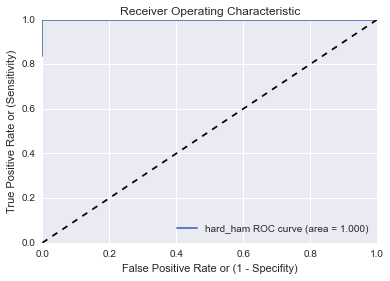

In [21]:
%matplotlib inline
from seaborn import plt

plot_roc_curve(preds, pred_proba, ???)

On Your Own
========

1. Read the Naïve Bayes documentation at [scikit-learn.org](http://scikit-learn.org/stable/modules/naive_bayes.html). There are three Naïve Bayes classifiers described. Which of the other two might also be appropriate for this task?
2. Explain your choice and apply it to either the spam/ham dataset (if you completed the pair assignment) or the newsgroups dataset (if you didn't).
3. Use grid search cross validation to find the best parameters for both the vectorizor and classifier.
    - Do different parameters for the vectorizor work better for this classifier?
4. Does this classifier do better or worse than the multinomial classifier?
5. Advanced: consider the descriptions of the two classifiers in light of which does better for this problem. Can you posit a theory as to why one classifier should do better than the other?